# Import Python Libraries

In [1]:
# SPDX-FileCopyrightText: 2023 NORCE
# SPDX-License-Identifier: GPL-3.0

""""mass2022
Script to run Data exploration and Machine Learning models
"""
###### Imports Python Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from pyswarm import pso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score 
import time
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading 

In [2]:
# #### Data Loading with NPY

# # Set the seed
# folder= ''
# np.random.seed(3)

# #Loading, reshaping and transforming in Pandas DataFrame the inputs
# inputs = np.load(folder + 'inputs.npy')
# inputs_reshaped = inputs.reshape(-1, 3)
# inputs_df= pd.DataFrame(inputs_reshaped, columns = ['Gas_rate','Permeability','Porosity'])

# #Loading and reshaping the outputs
# # CO2 Retained 
# output1 = np.load(folder + 'co2_retained.npy').reshape(-1, 1)

# # Oil Production
# output2 = np.load(folder + 'oil_production_total.npy').reshape(-1, 1)


# # Transforming outputs in Pandas DatFrame 
# outputs = np.stack([output1, output2], axis=1)
# outputs_reshaped = outputs.reshape(-1,2)
# outputs_df = pd.DataFrame(outputs_reshaped, columns = ['CO2_retained','Oilproduction'])

# # Dataframe with inputs and outputs
# data = pd.concat([inputs_df,outputs_df], axis=1)

In [3]:
sag_7 = pd.read_csv("foam_random_seed-7_simulation_results.csv")
sag_7_lhs = pd.read_csv("foam_lhs_seed-7_simulation_results.csv")

sag_7.head()

,Gas Injection Rate (GRATES),Water Injection Rate (WRATES),oil_pro_vol,wat_inj_vol,wat_pro_vol,gas_inj_vol,gas_pro_vol,gas_retained,co2_injected,co2_backprod,co2_retained,prod_bhp,inj_bhp,ratio_oil_to_inj_vol
0,1305.233157,14381.348210,19014876.0,26015982.0,2.719546e+06,2382050.5,11310154.0,-8928103.5,0.0,0.0,0.0,2400.0,0.0,0.669584
1,4119.675169,9697.126947,17128616.0,17697256.0,2.704846e+05,7518407.0,12595542.0,-5077135.0,0.0,0.0,0.0,2400.0,0.0,0.679285
2,2753.636926,5056.419539,10577333.0,9227966.0,1.771352e+05,5025387.5,7181275.0,-2155887.5,0.0,0.0,0.0,2400.0,0.0,0.742094
3,3893.860711,14992.083014,19767684.0,26100408.0,3.991369e+06,7106296.0,13271023.0,-6164727.0,0.0,0.0,0.0,2400.0,0.0,0.595292
4,4911.958048,5477.732127,12421012.0,9996861.0,2.117302e+05,8964323.0,10183787.0,-1219464.0,0.0,0.0,0.0,2400.0,0.0,0.655076


# 2. Data Preprocessing

## 2.1. EDA

In [4]:
# Variables information
sag_7.info()
column_name=sag_7.columns
print(column_name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Gas Injection Rate (GRATES)    300 non-null    float64
 1   Water Injection Rate (WRATES)  300 non-null    float64
 2   oil_pro_vol                    300 non-null    float64
 3   wat_inj_vol                    300 non-null    float64
 4   wat_pro_vol                    300 non-null    float64
 5   gas_inj_vol                    300 non-null    float64
 6   gas_pro_vol                    300 non-null    float64
 7   gas_retained                   300 non-null    float64
 8   co2_injected                   300 non-null    float64
 9   co2_backprod                   300 non-null    float64
 10  co2_retained                   300 non-null    float64
 11  prod_bhp                       300 non-null    float64
 12  inj_bhp                        300 non-null    flo

In [5]:
# Rename columns
sag_7 = sag_7.rename(columns={"Gas Injection Rate (GRATES)": "qg", "Water Injection Rate (WRATES)":"qw"})
sag_7_lhs = sag_7_lhs.rename(columns={"Gas Injection Rate (GRATES)": "qg", "Water Injection Rate (WRATES)":"qw"})


# Data with variables selected
sag_7 = sag_7[["qg", "qw", "gas_pro_vol","co2_retained", "oil_pro_vol"]]
sag_7_lhs = sag_7[["qg", "qw", "gas_pro_vol","co2_retained", "oil_pro_vol"]]

display(sag_7)
display(sag_7_lhs)

,qg,qw,gas_pro_vol,co2_retained,oil_pro_vol
0,1305.233157,14381.348210,11310154.0,0.0,19014876.0
1,4119.675169,9697.126947,12595542.0,0.0,17128616.0
2,2753.636926,5056.419539,7181275.0,0.0,10577333.0
3,3893.860711,14992.083014,13271023.0,0.0,19767684.0
4,4911.958048,5477.732127,10183787.0,0.0,12421012.0
...,...,...,...,...,...
295,1365.167160,14590.077782,11349250.0,0.0,19049596.0
296,3033.406704,6521.028684,8718435.0,0.0,12574081.0
297,1474.519281,5506.435277,6073781.0,0.0,10213202.0
298,1859.151405,5674.526741,6639844.5,0.0,10716105.0


,qg,qw,gas_pro_vol,co2_retained,oil_pro_vol
0,1305.233157,14381.348210,11310154.0,0.0,19014876.0
1,4119.675169,9697.126947,12595542.0,0.0,17128616.0
2,2753.636926,5056.419539,7181275.0,0.0,10577333.0
3,3893.860711,14992.083014,13271023.0,0.0,19767684.0
4,4911.958048,5477.732127,10183787.0,0.0,12421012.0
...,...,...,...,...,...
295,1365.167160,14590.077782,11349250.0,0.0,19049596.0
296,3033.406704,6521.028684,8718435.0,0.0,12574081.0
297,1474.519281,5506.435277,6073781.0,0.0,10213202.0
298,1859.151405,5674.526741,6639844.5,0.0,10716105.0


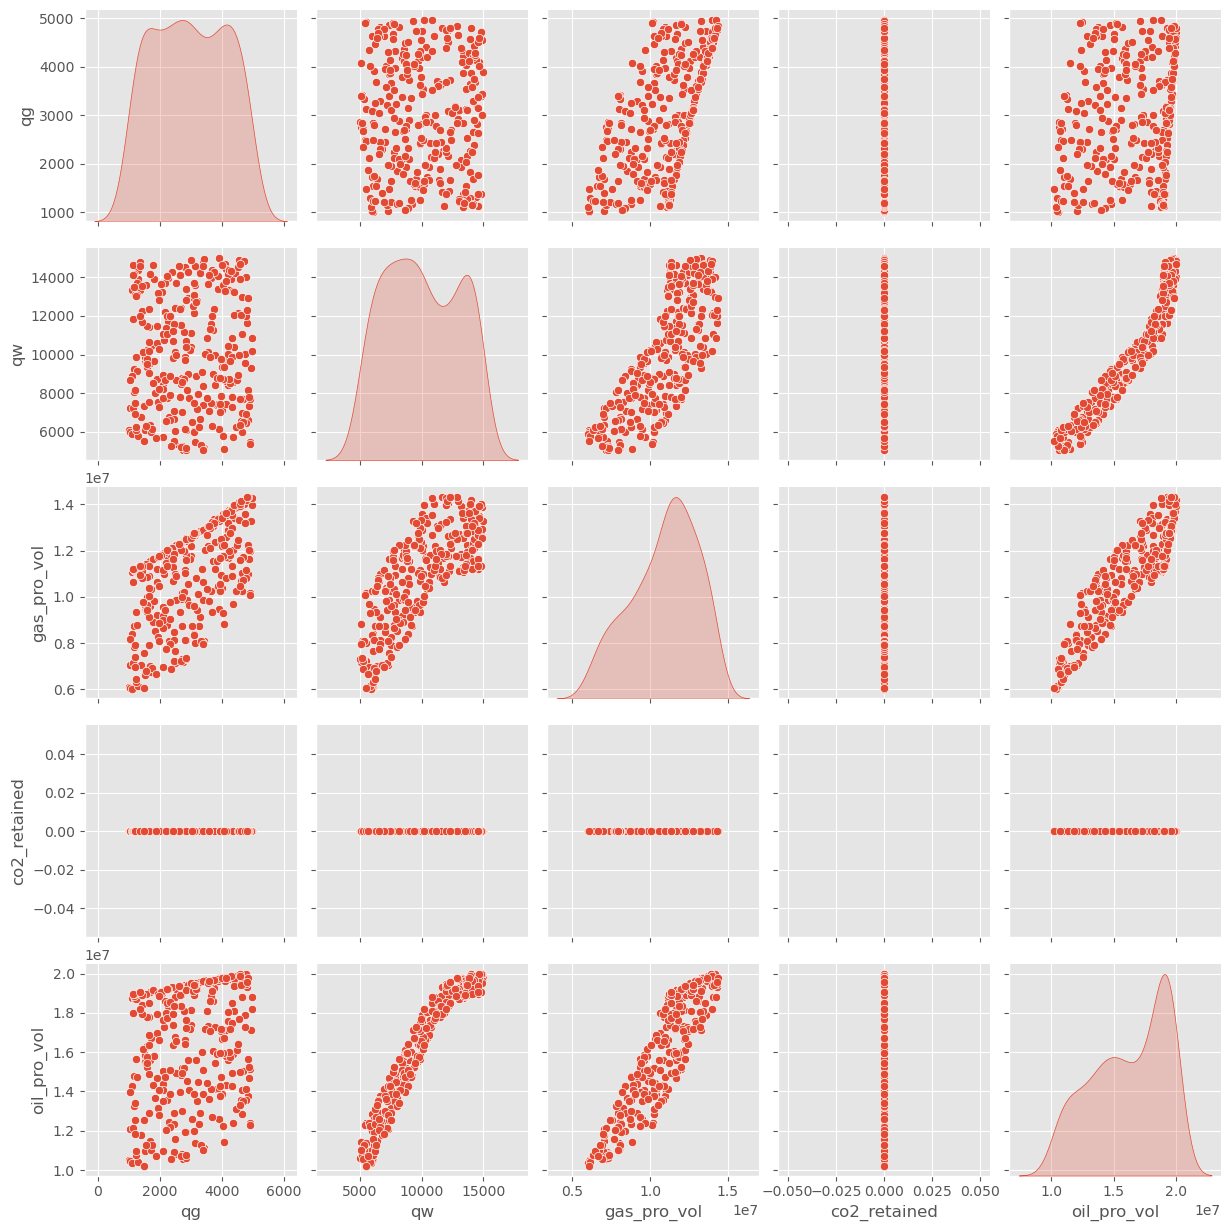

In [6]:
# Pairplot to check features distributions
sns.pairplot(sag_7, diag_kind="kde")
plt.show()

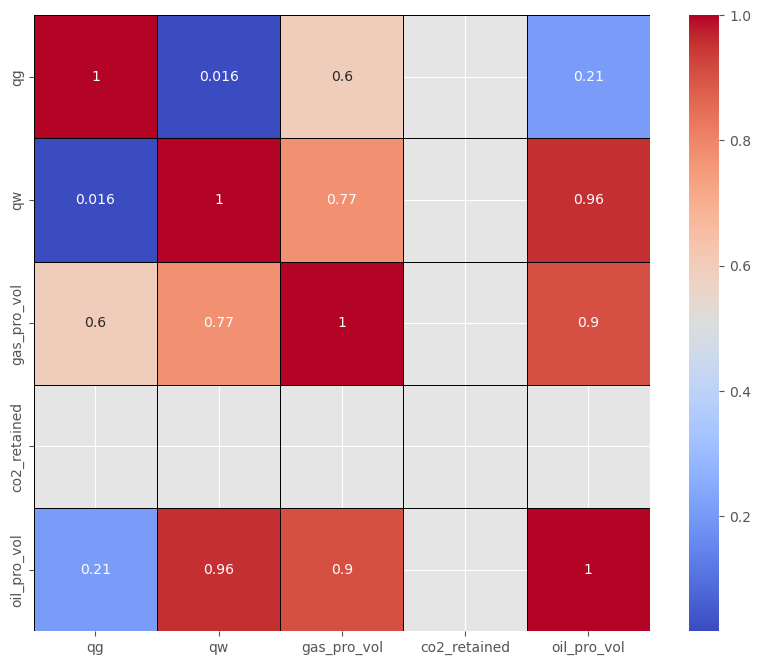

In [7]:
# Heatmap to check correlations between features

# Get pearson correlations
cor = sag_7.corr(method='pearson')

# Build the plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cor, annot=True, square=True, linecolor="black", lw=0.6, cmap="coolwarm", ax=ax)
plt.show()

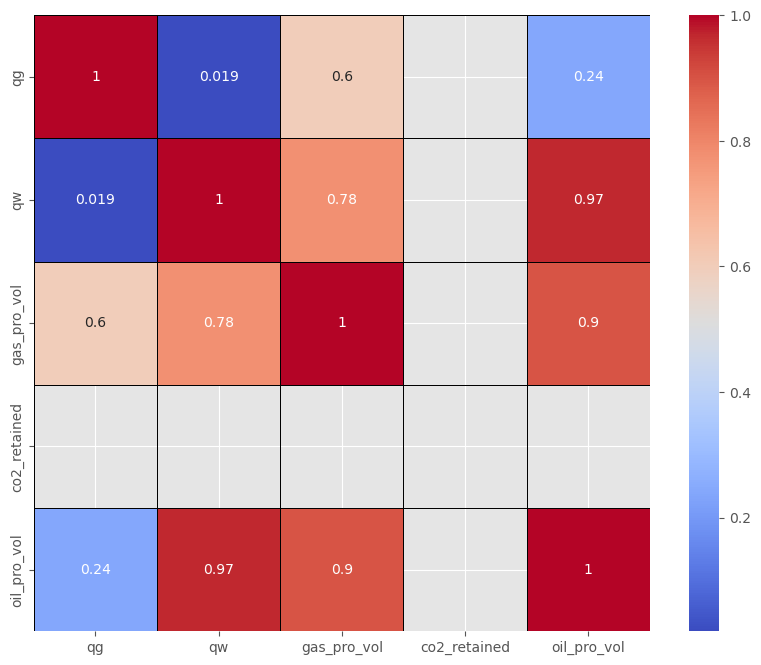

In [8]:
# Heatmap to check correlations bewteen features

# Get spearman correlations
cor = sag_7.corr(method='spearman')

# Build the plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cor, annot=True, square=True, linecolor="black", lw=0.6, cmap="coolwarm", ax=ax)
plt.show()

## 2.2. Check for Outliers

{'qg': [], 'qw': [], 'gas_pro_vol': [], 'co2_retained': [], 'oil_pro_vol': []}


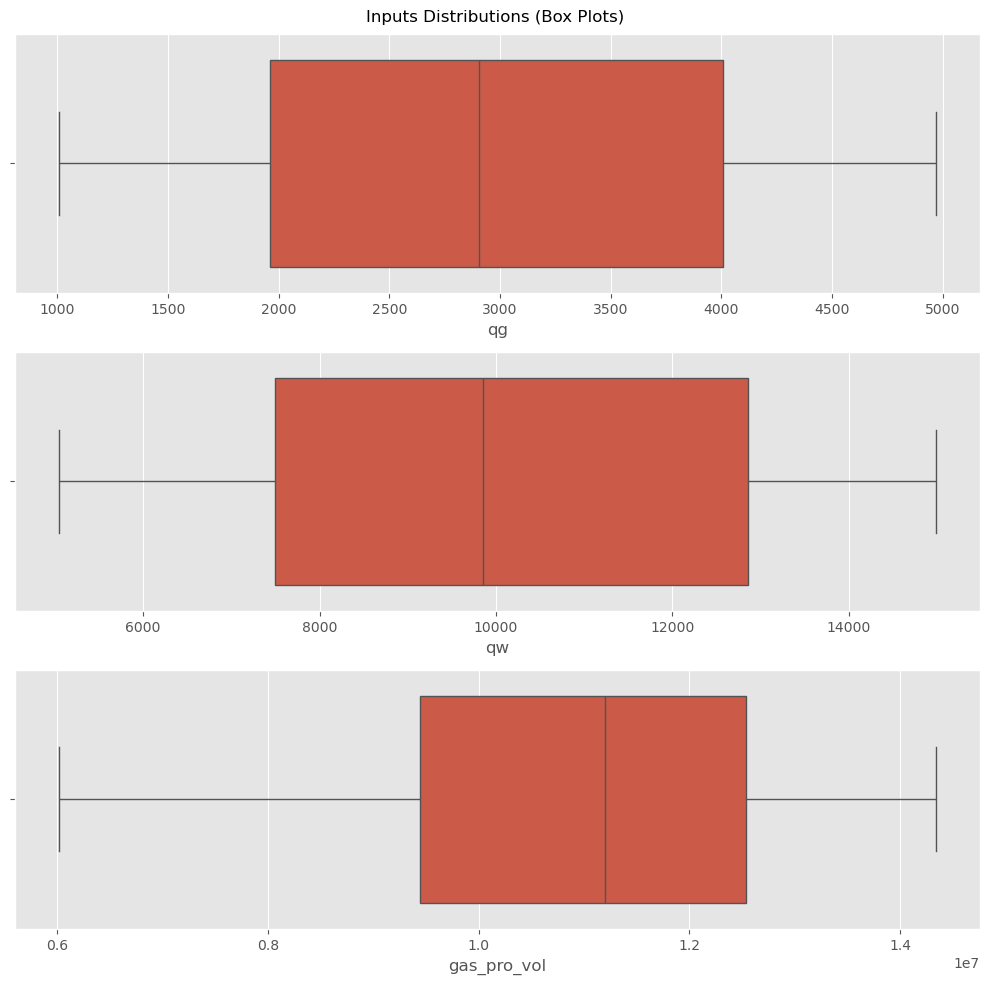

In [9]:
# Check if outliers exist

# check outliers using z-score
# Define a function to detect outliers
def detect_outliers_for_columns(data, columns):
    outliers_dict = {}
    threshold = 3

    for column_name in columns:
        if column_name in data.columns:
            data_array = data[column_name].values  # Extract the column as a NumPy array
            mean = np.mean(data_array)
            std = np.std(data_array)
            
            # Calculate outliers using the z-score
            outliers = [i for i in data_array if np.abs((i - mean) / std) > threshold]
            outliers_dict[column_name] = outliers
        else:
            print(f"Column '{column_name}' not found in the DataFrame.")
    
    return outliers_dict


# Specify the columns you are interested in
columns_of_interest = ["qg", "qw", "gas_pro_vol", "co2_retained", "oil_pro_vol"]

# Detect outliers for the specified columns
outliers = detect_outliers_for_columns(sag_7, columns_of_interest)
print(outliers)

# check for outliers using boxplots
cols = sag_7.columns[:3].values 

fig, ax = plt.subplots(nrows=len(cols), figsize=(10, 10))
for axes, col in zip(ax, cols):
    sns.boxplot(x=sag_7[col], ax=axes)

fig.suptitle("Inputs Distributions (Box Plots)")
plt.tight_layout()
plt.show()

# 3. ML Algorithms Training

## 3.1.1. Data Split (Training, Testing, and Validation) - SAG (Random)

In [10]:
### Train-Test-Validation Split
# Step 1: Split initial 90% for training/testing and get the validation dataset
train_test_data, validation_data = train_test_split(sag_7, test_size=0.1, random_state=42)


# Step 2: Get train and test datasets from the remaining 90% of main dataset
train_data, test_data = train_test_split(train_test_data, test_size=0.2, random_state=42)


print("Training Data (80%):")
print(train_data.shape)

print("\nTesting Data (20%):")
print(test_data.shape)

print("\nValidation Data (10% of dataset):")
print(validation_data.shape)

Training Data (80%):
(216, 5)

Testing Data (20%):
(54, 5)

Validation Data (10% of dataset):
(30, 5)


## 3.1.2. Data Split (Training, Testing, and Validation) - SAG (LHS)

In [11]:
### Train-Test-Validation Split
# Step 1: Split initial 90% for training/testing and get the validation dataset
train_test_data_lhs, validation_data_lhs = train_test_split(sag_7_lhs, test_size=0.1, random_state=42)


# Step 2: Get train and test datasets from the remaining 90% of main dataset
train_data_lhs, test_data_lhs = train_test_split(train_test_data_lhs, test_size=0.2, random_state=42)


print("Training Data (80%):")
print(train_data_lhs.shape)

print("\nTesting Data (20%):")
print(test_data_lhs.shape)

print("\nValidation Data (10% of dataset):")
print(validation_data_lhs.shape)

Training Data (80%):
(216, 5)

Testing Data (20%):
(54, 5)

Validation Data (10% of dataset):
(30, 5)


In [12]:
# Features variables and target variable for training, testing and validation Random (SAG)
# # Data with variables selected [["qg", "qw", "gas_pro_vol","co2_retained", "oil_pro_vol"]]

X_train_sag  = train_data.iloc[:, :2].values
y_train_sag_qo = train_data.iloc[:, -1].values # -1 oil_pro_vol
y_train_sag_qg = train_data.iloc[:, -3].values # -3 gas_prod_vol

X_test_sag = test_data.iloc[:, :2].values
y_test_sag_qo = test_data.iloc[:, -1].values
y_test_sag_qg = test_data.iloc[:, -3].values

X_val_sag = validation_data.iloc[:, :2].values
y_val_sag_qo = validation_data.iloc[:, -1].values
y_val_sag_qg = validation_data.iloc[:, -3].values

# ## if you are predicting oil production, enable this line
# y_train, y_test, y_val = y_train_1, y_test_1 , y_val_1

# ## if you are predicting gas production, enable this line
# y_train, y_test, y_val = y_train_2, y_test_2 , y_val_2

print(y_train_sag_qg.shape)

print(y_test_sag_qg.shape)

print(y_val_sag_qg.shape)

(216,)
(54,)
(30,)


In [13]:
X_train_sag_lhs  = train_data_lhs.iloc[:, :2].values
y_train_sag_qo_lhs = train_data_lhs.iloc[:, -1].values # -1 oil_pro_vol
y_train_sag_qg_lhs = train_data_lhs.iloc[:, -3].values # -3 gas_prod_vol

X_test_sag_lhs = test_data_lhs.iloc[:, :2].values
y_test_sag_qo_lhs = test_data_lhs.iloc[:, -1].values
y_test_sag_qg_lhs = test_data_lhs.iloc[:, -3].values

X_val_sag_lhs = validation_data_lhs.iloc[:, :2].values
y_val_sag_qo_lhs = validation_data_lhs.iloc[:, -1].values
y_val_sag_qg_lhs = validation_data_lhs.iloc[:, -3].values

# ## if you are predicting oil production, enable this line
# y_train, y_test, y_val = y_train_1, y_test_1 , y_val_1

# ## if you are predicting gas production, enable this line
# y_train, y_test, y_val = y_train_2, y_test_2 , y_val_2

print(y_train_sag_qg_lhs.shape)

print(y_test_sag_qg_lhs.shape)

print(y_val_sag_qg_lhs.shape)

(216,)
(54,)
(30,)


## 3.2. Models Training, Optimization, and Evaluation without optimization (Random)

In [14]:
# Initialize regressors
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor()

results_wo = {}
# Evaluate models on test data

def training_model(model, X_train, X_test, y_train, y_test, label, label_data):
    y_fit = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{label} -> R²_{label_data}: {r2:.4f},  RMSE_{label_data}: {rmse:.4f}")
    results_wo[label] = {"R²_"+label_data: r2, "RMSE_"+label_data: rmse}
    
    return r2, rmse

In [15]:
print("\n Regression metrics with test data for Oil Production (Qo):")
training_model(knn, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "KNN_test_qo", "test")
training_model(dt, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "DT_test_qo", "test")
training_model(rf, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "RF_test_qo", "test")
training_model(gbr, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg):")
training_model(knn, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "KNN_test_qg", "test")
training_model(dt, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "DT_test_qg", "test")
training_model(rf, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "RF_test_qg", "test")
training_model(gbr, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo):
KNN_test_qo -> R²_test: 0.9961,  RMSE_test: 179374.6177
DT_test_qo -> R²_test: 0.9891,  RMSE_test: 298428.3891
RF_test_qo -> R²_test: 0.9953,  RMSE_test: 195154.2848
GBR_test_qo -> R²_test: 0.9964,  RMSE_test: 171317.9508

 Regression metrics with test data for Gas Production (Qg):
KNN_test_qg -> R²_test: 0.9915,  RMSE_test: 193991.2603
DT_test_qg -> R²_test: 0.9770,  RMSE_test: 318854.0407
RF_test_qg -> R²_test: 0.9897,  RMSE_test: 213636.1577
GBR_test_qg -> R²_test: 0.9917,  RMSE_test: 191811.3300


(0.9916588041580461, np.float64(191811.32997555833))

In [16]:
test_results_df = pd.DataFrame(results_wo).T
test_results_df

,R²_test,RMSE_test
KNN_test_qo,0.996069,179374.617679
DT_test_qo,0.989119,298428.389133
RF_test_qo,0.995347,195154.284752
GBR_test_qo,0.996414,171317.950759
KNN_test_qg,0.991468,193991.260300
DT_test_qg,0.976950,318854.040736
RF_test_qg,0.989653,213636.157728
GBR_test_qg,0.991659,191811.329976


In [17]:
results_wo = {}
print("\n Regression metrics with validation data for Oil Production (Qo):")
training_model(knn, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "KNN_val_qo","val")
training_model(dt, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "DT_val_qo","val")
training_model(rf, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "RF_val_qo","val")
training_model(gbr, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg):")
training_model(knn, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "KNN_val_qg","val")
training_model(dt, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "DT_val_qg","val")
training_model(rf, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "RF_val_qg","val")
training_model(gbr, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo):
KNN_val_qo -> R²_val: 0.9933,  RMSE_val: 229878.6721
DT_val_qo -> R²_val: 0.9916,  RMSE_val: 257406.2078
RF_val_qo -> R²_val: 0.9945,  RMSE_val: 208532.1391
GBR_val_qo -> R²_val: 0.9957,  RMSE_val: 183795.2088

 Regression metrics with validation data for Gas Production (Qg):
KNN_val_qg -> R²_val: 0.9861,  RMSE_val: 234181.2314
DT_val_qg -> R²_val: 0.9697,  RMSE_val: 345846.6297
RF_val_qg -> R²_val: 0.9874,  RMSE_val: 222605.8278
GBR_val_qg -> R²_val: 0.9867,  RMSE_val: 229090.8287


(0.986685627542602, np.float64(229090.82873964278))

In [18]:
val_results_df = pd.DataFrame(results_wo).T
val_results_df

,R²_val,RMSE_val
KNN_val_qo,0.993309,229878.672147
DT_val_qo,0.991611,257406.207849
RF_val_qo,0.994494,208532.139099
GBR_val_qo,0.995723,183795.208790
KNN_val_qg,0.986087,234181.231370
DT_val_qg,0.969656,345846.629676
RF_val_qg,0.987429,222605.827839
GBR_val_qg,0.986686,229090.828740


In [19]:
sag_df_ran = pd.concat([test_results_df, val_results_df], axis=1)
sag_df_ran

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996069,179374.617679,NaN,NaN
DT_test_qo,0.989119,298428.389133,NaN,NaN
RF_test_qo,0.995347,195154.284752,NaN,NaN
GBR_test_qo,0.996414,171317.950759,NaN,NaN
KNN_test_qg,0.991468,193991.260300,NaN,NaN
DT_test_qg,0.976950,318854.040736,NaN,NaN
RF_test_qg,0.989653,213636.157728,NaN,NaN
GBR_test_qg,0.991659,191811.329976,NaN,NaN
KNN_val_qo,NaN,NaN,0.993309,229878.672147
DT_val_qo,NaN,NaN,0.991611,257406.207849


In [20]:
# Reset the index to expose the row labels as a column
sag_df_ran = sag_df_ran.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_ran['Models'] = sag_df_ran['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_ran['Property'] = sag_df_ran['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_ran = sag_df_ran.pivot(index='Models', columns='Property', values=list(sag_df_ran.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_ran.columns = [f"{col[1]}_{col[0]}" for col in sag_df_ran.columns]

# Reset index to get 'Models' as a column
sag_df_ran.reset_index(inplace=True)

sag_df_ran

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.976950,0.989119,NaN,NaN,318854.040736,298428.389133,NaN,NaN,NaN,NaN,0.969656,0.991611,NaN,NaN,345846.629676,257406.207849
1,GBR,0.991659,0.996414,NaN,NaN,191811.329976,171317.950759,NaN,NaN,NaN,NaN,0.986686,0.995723,NaN,NaN,229090.828740,183795.208790
2,KNN,0.991468,0.996069,NaN,NaN,193991.260300,179374.617679,NaN,NaN,NaN,NaN,0.986087,0.993309,NaN,NaN,234181.231370,229878.672147
3,RF,0.989653,0.995347,NaN,NaN,213636.157728,195154.284752,NaN,NaN,NaN,NaN,0.987429,0.994494,NaN,NaN,222605.827839,208532.139099


In [21]:
sag_df_ran.to_csv("results/sag_7_ran.csv")

## 3.3. Models Training, Optimization, and Evaluation without optimization (LHS)

In [22]:
results_wo = {}

print("\n Regression metrics with test data for Oil Production (Qo):")
training_model(knn, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "KNN_test_qo", "test")
training_model(dt, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "DT_test_qo", "test")
training_model(rf, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "RF_test_qo", "test")
training_model(gbr, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg):")
training_model(knn, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "KNN_test_qg", "test")
training_model(dt, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "DT_test_qg", "test")
training_model(rf, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "RF_test_qg", "test")
training_model(gbr, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo):
KNN_test_qo -> R²_test: 0.9961,  RMSE_test: 179374.6177
DT_test_qo -> R²_test: 0.9891,  RMSE_test: 298428.3891
RF_test_qo -> R²_test: 0.9953,  RMSE_test: 195154.2848
GBR_test_qo -> R²_test: 0.9964,  RMSE_test: 171287.0757

 Regression metrics with test data for Gas Production (Qg):
KNN_test_qg -> R²_test: 0.9915,  RMSE_test: 193991.2603
DT_test_qg -> R²_test: 0.9770,  RMSE_test: 318854.0407
RF_test_qg -> R²_test: 0.9897,  RMSE_test: 213636.1577
GBR_test_qg -> R²_test: 0.9916,  RMSE_test: 192178.8323


(0.9916268107917392, np.float64(192178.83225381555))

In [23]:
test_results_df_lhs = pd.DataFrame(results_wo).T
test_results_df_lhs

,R²_test,RMSE_test
KNN_test_qo,0.996069,179374.617679
DT_test_qo,0.989119,298428.389133
RF_test_qo,0.995347,195154.284752
GBR_test_qo,0.996415,171287.075656
KNN_test_qg,0.991468,193991.260300
DT_test_qg,0.976950,318854.040736
RF_test_qg,0.989653,213636.157728
GBR_test_qg,0.991627,192178.832254


In [24]:
results_wo = {}
print("\n Regression metrics with validation data for Oil Production (Qo):")
training_model(knn, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "KNN_val_qo","val")
training_model(dt, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "DT_val_qo","val")
training_model(rf, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "RF_val_qo","val")
training_model(gbr, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg):")
training_model(knn, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "KNN_val_qg","val")
training_model(dt, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "DT_val_qg","val")
training_model(rf, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "RF_val_qg","val")
training_model(gbr, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo):
KNN_val_qo -> R²_val: 0.9933,  RMSE_val: 229878.6721
DT_val_qo -> R²_val: 0.9916,  RMSE_val: 257406.2078
RF_val_qo -> R²_val: 0.9945,  RMSE_val: 208532.1391
GBR_val_qo -> R²_val: 0.9957,  RMSE_val: 183811.2950

 Regression metrics with validation data for Gas Production (Qg):
KNN_val_qg -> R²_val: 0.9861,  RMSE_val: 234181.2314
DT_val_qg -> R²_val: 0.9697,  RMSE_val: 345846.6297
RF_val_qg -> R²_val: 0.9874,  RMSE_val: 222605.8278
GBR_val_qg -> R²_val: 0.9867,  RMSE_val: 229064.6998


(0.9866886645089117, np.float64(229064.69980230252))

In [25]:
val_results_df_lhs = pd.DataFrame(results_wo).T
val_results_df_lhs

,R²_val,RMSE_val
KNN_val_qo,0.993309,229878.672147
DT_val_qo,0.991611,257406.207849
RF_val_qo,0.994494,208532.139099
GBR_val_qo,0.995722,183811.294973
KNN_val_qg,0.986087,234181.231370
DT_val_qg,0.969656,345846.629676
RF_val_qg,0.987429,222605.827839
GBR_val_qg,0.986689,229064.699802


In [26]:
sag_df_lhs = pd.concat([test_results_df_lhs, val_results_df_lhs], axis=1)
sag_df_lhs

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996069,179374.617679,NaN,NaN
DT_test_qo,0.989119,298428.389133,NaN,NaN
RF_test_qo,0.995347,195154.284752,NaN,NaN
GBR_test_qo,0.996415,171287.075656,NaN,NaN
KNN_test_qg,0.991468,193991.260300,NaN,NaN
DT_test_qg,0.976950,318854.040736,NaN,NaN
RF_test_qg,0.989653,213636.157728,NaN,NaN
GBR_test_qg,0.991627,192178.832254,NaN,NaN
KNN_val_qo,NaN,NaN,0.993309,229878.672147
DT_val_qo,NaN,NaN,0.991611,257406.207849


In [27]:
# Reset the index to expose the row labels as a column
sag_df_lhs = sag_df_lhs.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_lhs['Models'] = sag_df_lhs['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_lhs['Property'] = sag_df_lhs['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_lhs = sag_df_lhs.pivot(index='Models', columns='Property', values=list(sag_df_lhs.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_lhs.columns = [f"{col[1]}_{col[0]}" for col in sag_df_lhs.columns]

# Reset index to get 'Models' as a column
sag_df_lhs.reset_index(inplace=True)

In [28]:
sag_df_lhs.to_csv("results/sag_7_lhs.csv")

## 3.3. Models Training, Optimization, and Evaluation (RandomizedSearchCV) - Random

In [29]:
# Call the Machine Learning Algorithms for regression
knn = KNeighborsRegressor()
gbr = GradientBoostingRegressor()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

In [30]:
# Define the hyperparameters to tune for each algorithm
knn_params = {'n_neighbors': np.arange(1, 31, 1)}
dt_params = {'max_depth': np.arange(2,20,1)}
gbr_params = {'n_estimators': np.arange(100, 1001, 100), "max_depth":[3, 5, 7]}
rf_params = {'max_depth': np.arange(5, 30, 1)}

In [31]:
# Function to train each model
results_ran = {}

def training_model_RS(model_name, param_grid, X_train, X_test, y_train, y_test, label, label_data):
    model = RandomizedSearchCV(model_name, n_iter=50, param_distributions=param_grid, scoring="r2", random_state=42)
    y_fit = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{label} -> R²_{label_data}: {r2:.4f},  RMSE_{label_data}: {rmse:.4f}")
    results_ran[label] = {"R²_"+label_data: r2, "RMSE_"+label_data: rmse}
    
    return r2, rmse

In [32]:
print("\n Regression metrics with test data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "KNN_test_qo", "test")
training_model_RS(dt, dt_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "DT_test_qo", "test")
training_model_RS(rf, rf_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "RF_test_qo", "test")
training_model_RS(gbr, gbr_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "KNN_test_qg", "test")
training_model_RS(dt, dt_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "DT_test_qg", "test")
training_model_RS(rf, rf_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "RF_test_qg", "test")
training_model_RS(gbr, gbr_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo) using RandomizedSearchCV:
KNN_test_qo -> R²_test: 0.9963,  RMSE_test: 173055.1631
DT_test_qo -> R²_test: 0.9923,  RMSE_test: 251819.7983
RF_test_qo -> R²_test: 0.9953,  RMSE_test: 195371.2024
GBR_test_qo -> R²_test: 0.9971,  RMSE_test: 155058.9227

 Regression metrics with test data for Gas Production (Qg) using RandomizedSearchCV:
KNN_test_qg -> R²_test: 0.9941,  RMSE_test: 161263.6168
DT_test_qg -> R²_test: 0.9622,  RMSE_test: 408372.2800
RF_test_qg -> R²_test: 0.9897,  RMSE_test: 212820.6934
GBR_test_qg -> R²_test: 0.9932,  RMSE_test: 173816.4374


(0.9931504586286221, np.float64(173816.43738421606))

In [33]:
test_results_df_Ran_ran = pd.DataFrame(results_ran).T
test_results_df_Ran_ran

,R²_test,RMSE_test
KNN_test_qo,0.996341,173055.163064
DT_test_qo,0.992252,251819.798312
RF_test_qo,0.995336,195371.202378
GBR_test_qo,0.997062,155058.922706
KNN_test_qg,0.994104,161263.616846
DT_test_qg,0.962191,408372.280002
RF_test_qg,0.989731,212820.693425
GBR_test_qg,0.993150,173816.437384


In [34]:
results_ran = {}
print("\n Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "KNN_val_qo","val")
training_model_RS(dt, dt_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "DT_val_qo","val")
training_model_RS(rf, rf_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "RF_val_qo","val")
training_model_RS(gbr, gbr_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "KNN_val_qg","val")
training_model_RS(dt, dt_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "DT_val_qg","val")
training_model_RS(rf, rf_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "RF_val_qg","val")
training_model_RS(gbr, gbr_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:
KNN_val_qo -> R²_val: 0.9935,  RMSE_val: 227059.7978
DT_val_qo -> R²_val: 0.9898,  RMSE_val: 284141.6618
RF_val_qo -> R²_val: 0.9945,  RMSE_val: 208758.3896
GBR_val_qo -> R²_val: 0.9963,  RMSE_val: 171259.3116

 Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:
KNN_val_qg -> R²_val: 0.9850,  RMSE_val: 243363.0736
DT_val_qg -> R²_val: 0.9544,  RMSE_val: 423734.6066
RF_val_qg -> R²_val: 0.9875,  RMSE_val: 222326.1508
GBR_val_qg -> R²_val: 0.9852,  RMSE_val: 241172.7686


(0.9852442314906948, np.float64(241172.7686440762))

In [35]:
val_results_df_Ran_ran = pd.DataFrame(results_ran).T
val_results_df_Ran_ran

,R²_val,RMSE_val
KNN_val_qo,0.993473,227059.797798
DT_val_qo,0.989778,284141.661824
RF_val_qo,0.994482,208758.389625
GBR_val_qo,0.996287,171259.311553
KNN_val_qg,0.984975,243363.073619
DT_val_qg,0.954449,423734.606612
RF_val_qg,0.987460,222326.150818
GBR_val_qg,0.985244,241172.768644


In [36]:
sag_df_ran_ran = pd.concat([test_results_df_Ran_ran, val_results_df_Ran_ran], axis=1)
sag_df_ran_ran

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996341,173055.163064,NaN,NaN
DT_test_qo,0.992252,251819.798312,NaN,NaN
RF_test_qo,0.995336,195371.202378,NaN,NaN
GBR_test_qo,0.997062,155058.922706,NaN,NaN
KNN_test_qg,0.994104,161263.616846,NaN,NaN
DT_test_qg,0.962191,408372.280002,NaN,NaN
RF_test_qg,0.989731,212820.693425,NaN,NaN
GBR_test_qg,0.993150,173816.437384,NaN,NaN
KNN_val_qo,NaN,NaN,0.993473,227059.797798
DT_val_qo,NaN,NaN,0.989778,284141.661824


In [37]:
# Reset the index to expose the row labels as a column
sag_df_ran_ran = sag_df_ran_ran.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_ran_ran['Models'] = sag_df_ran_ran['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_ran_ran['Property'] = sag_df_ran_ran['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_ran_ran = sag_df_ran_ran.pivot(index='Models', columns='Property', values=list(sag_df_ran_ran.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_ran_ran.columns = [f"{col[1]}_{col[0]}" for col in sag_df_ran_ran.columns]

# Reset index to get 'Models' as a column
sag_df_ran_ran.reset_index(inplace=True)

sag_df_ran_ran

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.962191,0.992252,NaN,NaN,408372.280002,251819.798312,NaN,NaN,NaN,NaN,0.954449,0.989778,NaN,NaN,423734.606612,284141.661824
1,GBR,0.993150,0.997062,NaN,NaN,173816.437384,155058.922706,NaN,NaN,NaN,NaN,0.985244,0.996287,NaN,NaN,241172.768644,171259.311553
2,KNN,0.994104,0.996341,NaN,NaN,161263.616846,173055.163064,NaN,NaN,NaN,NaN,0.984975,0.993473,NaN,NaN,243363.073619,227059.797798
3,RF,0.989731,0.995336,NaN,NaN,212820.693425,195371.202378,NaN,NaN,NaN,NaN,0.987460,0.994482,NaN,NaN,222326.150818,208758.389625


In [38]:
sag_df_ran_ran.to_csv("results/sag_7_ran_ran.csv")

## 3.4. Models Training, Optimization, and Evaluation (RandomizedSearchCV) - LHS

In [39]:
results_ran = {}

print("\n Regression metrics with test data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "KNN_test_qo", "test")
training_model_RS(dt, dt_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "DT_test_qo", "test")
training_model_RS(rf, rf_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "RF_test_qo", "test")
training_model_RS(gbr, gbr_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "KNN_test_qg", "test")
training_model_RS(dt, dt_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "DT_test_qg", "test")
training_model_RS(rf, rf_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "RF_test_qg", "test")
training_model_RS(gbr, gbr_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo) using RandomizedSearchCV:
KNN_test_qo -> R²_test: 0.9963,  RMSE_test: 173055.1631
DT_test_qo -> R²_test: 0.9923,  RMSE_test: 251819.7983
RF_test_qo -> R²_test: 0.9953,  RMSE_test: 195371.2024
GBR_test_qo -> R²_test: 0.9971,  RMSE_test: 155015.4928

 Regression metrics with test data for Gas Production (Qg) using RandomizedSearchCV:
KNN_test_qg -> R²_test: 0.9941,  RMSE_test: 161263.6168
DT_test_qg -> R²_test: 0.9622,  RMSE_test: 408372.2800
RF_test_qg -> R²_test: 0.9897,  RMSE_test: 212820.6934
GBR_test_qg -> R²_test: 0.9932,  RMSE_test: 173251.8186


(0.9931948859371431, np.float64(173251.8186221486))

In [40]:
test_results_df_Ran_lhs = pd.DataFrame(results_ran).T
test_results_df_Ran_lhs

,R²_test,RMSE_test
KNN_test_qo,0.996341,173055.163064
DT_test_qo,0.992252,251819.798312
RF_test_qo,0.995336,195371.202378
GBR_test_qo,0.997064,155015.492771
KNN_test_qg,0.994104,161263.616846
DT_test_qg,0.962191,408372.280002
RF_test_qg,0.989731,212820.693425
GBR_test_qg,0.993195,173251.818622


In [41]:
results_ran = {}
print("\n Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "KNN_val_qo","val")
training_model_RS(dt, dt_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "DT_val_qo","val")
training_model_RS(rf, rf_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "RF_val_qo","val")
training_model_RS(gbr, gbr_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_RS(knn, knn_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "KNN_val_qg","val")
training_model_RS(dt, dt_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "DT_val_qg","val")
training_model_RS(rf, rf_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "RF_val_qg","val")
training_model_RS(gbr, gbr_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:
KNN_val_qo -> R²_val: 0.9935,  RMSE_val: 227059.7978
DT_val_qo -> R²_val: 0.9898,  RMSE_val: 284141.6618
RF_val_qo -> R²_val: 0.9945,  RMSE_val: 208758.3896
GBR_val_qo -> R²_val: 0.9963,  RMSE_val: 170812.4460

 Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:
KNN_val_qg -> R²_val: 0.9850,  RMSE_val: 243363.0736
DT_val_qg -> R²_val: 0.9544,  RMSE_val: 423734.6066
RF_val_qg -> R²_val: 0.9875,  RMSE_val: 222326.1508
GBR_val_qg -> R²_val: 0.9853,  RMSE_val: 240469.5386


(0.9853301580293817, np.float64(240469.53863625377))

In [42]:
val_results_df_Ran_lhs = pd.DataFrame(results_ran).T
val_results_df_Ran_lhs

,R²_val,RMSE_val
KNN_val_qo,0.993473,227059.797798
DT_val_qo,0.989778,284141.661824
RF_val_qo,0.994482,208758.389625
GBR_val_qo,0.996306,170812.445989
KNN_val_qg,0.984975,243363.073619
DT_val_qg,0.954449,423734.606612
RF_val_qg,0.987460,222326.150818
GBR_val_qg,0.985330,240469.538636


In [43]:
sag_df_ran_lhs = pd.concat([test_results_df_Ran_lhs, val_results_df_Ran_lhs], axis=1)
sag_df_ran_lhs

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996341,173055.163064,NaN,NaN
DT_test_qo,0.992252,251819.798312,NaN,NaN
RF_test_qo,0.995336,195371.202378,NaN,NaN
GBR_test_qo,0.997064,155015.492771,NaN,NaN
KNN_test_qg,0.994104,161263.616846,NaN,NaN
DT_test_qg,0.962191,408372.280002,NaN,NaN
RF_test_qg,0.989731,212820.693425,NaN,NaN
GBR_test_qg,0.993195,173251.818622,NaN,NaN
KNN_val_qo,NaN,NaN,0.993473,227059.797798
DT_val_qo,NaN,NaN,0.989778,284141.661824


In [44]:
# Reset the index to expose the row labels as a column
sag_df_ran_lhs = sag_df_ran_lhs.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_ran_lhs['Models'] = sag_df_ran_lhs['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_ran_lhs['Property'] = sag_df_ran_lhs['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_ran_lhs = sag_df_ran_lhs.pivot(index='Models', columns='Property', values=list(sag_df_ran_lhs.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_ran_lhs.columns = [f"{col[1]}_{col[0]}" for col in sag_df_ran_lhs.columns]

# Reset index to get 'Models' as a column
sag_df_ran_lhs.reset_index(inplace=True)

sag_df_ran_lhs

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.962191,0.992252,NaN,NaN,408372.280002,251819.798312,NaN,NaN,NaN,NaN,0.954449,0.989778,NaN,NaN,423734.606612,284141.661824
1,GBR,0.993195,0.997064,NaN,NaN,173251.818622,155015.492771,NaN,NaN,NaN,NaN,0.985330,0.996306,NaN,NaN,240469.538636,170812.445989
2,KNN,0.994104,0.996341,NaN,NaN,161263.616846,173055.163064,NaN,NaN,NaN,NaN,0.984975,0.993473,NaN,NaN,243363.073619,227059.797798
3,RF,0.989731,0.995336,NaN,NaN,212820.693425,195371.202378,NaN,NaN,NaN,NaN,0.987460,0.994482,NaN,NaN,222326.150818,208758.389625


In [45]:
sag_df_ran_lhs.to_csv("results/sag_7_lhs_ran.csv")

## 3.5. Models Training, Optimization, and Evaluation (GridSearchCV) - Random

In [46]:
# Function to train each model
results_gr = {}

def training_model_GS(model_name, param_grid, X_train, X_test, y_train, y_test, label, label_data):
    model = GridSearchCV(model_name, param_grid=param_grid, scoring="r2")
    y_fit = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{label} -> R²_{label_data}: {r2:.4f},  RMSE_{label_data}: {rmse:.4f}")
    results_gr[label] = {"R²_"+label_data: r2, "RMSE_"+label_data: rmse}
    
    return r2, rmse

In [47]:
print("\n Regression metrics with test data for Oil Production (Qo) using GridSearchCV:")
training_model_GS(knn, knn_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "KNN_test_qo", "test")
training_model_GS(dt, dt_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "DT_test_qo", "test")
training_model_GS(rf, rf_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "RF_test_qo", "test")
training_model_GS(gbr, gbr_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg) using GridSearchCV:")
training_model_GS(knn, knn_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "KNN_test_qg", "test")
training_model_GS(dt, dt_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "DT_test_qg", "test")
training_model_GS(rf, rf_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "RF_test_qg", "test")
training_model_GS(gbr, gbr_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo) using GridSearchCV:
KNN_test_qo -> R²_test: 0.9963,  RMSE_test: 173055.1631
DT_test_qo -> R²_test: 0.9923,  RMSE_test: 251819.7983
RF_test_qo -> R²_test: 0.9953,  RMSE_test: 195371.2024
GBR_test_qo -> R²_test: 0.9970,  RMSE_test: 155937.9001

 Regression metrics with test data for Gas Production (Qg) using GridSearchCV:
KNN_test_qg -> R²_test: 0.9941,  RMSE_test: 161263.6168
DT_test_qg -> R²_test: 0.9622,  RMSE_test: 408372.2800
RF_test_qg -> R²_test: 0.9897,  RMSE_test: 212820.6934
GBR_test_qg -> R²_test: 0.9932,  RMSE_test: 173614.2807


(0.9931663820439333, np.float64(173614.28065433278))

In [48]:
test_results_df_Grid_ran = pd.DataFrame(results_gr).T
test_results_df_Grid_ran

,R²_test,RMSE_test
KNN_test_qo,0.996341,173055.163064
DT_test_qo,0.992252,251819.798312
RF_test_qo,0.995336,195371.202378
GBR_test_qo,0.997029,155937.900097
KNN_test_qg,0.994104,161263.616846
DT_test_qg,0.962191,408372.280002
RF_test_qg,0.989731,212820.693425
GBR_test_qg,0.993166,173614.280654


In [49]:
results_gr = {}
print("\n Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_GS(knn, knn_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "KNN_val_qo","val")
training_model_GS(dt, dt_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "DT_val_qo","val")
training_model_GS(rf, rf_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "RF_val_qo","val")
training_model_GS(gbr, gbr_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_GS(knn, knn_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "KNN_val_qg","val")
training_model_GS(dt, dt_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "DT_val_qg","val")
training_model_GS(rf, rf_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "RF_val_qg","val")
training_model_GS(gbr, gbr_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:
KNN_val_qo -> R²_val: 0.9935,  RMSE_val: 227059.7978
DT_val_qo -> R²_val: 0.9898,  RMSE_val: 284141.6618
RF_val_qo -> R²_val: 0.9945,  RMSE_val: 208758.3896
GBR_val_qo -> R²_val: 0.9963,  RMSE_val: 170610.0021

 Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:
KNN_val_qg -> R²_val: 0.9850,  RMSE_val: 243363.0736
DT_val_qg -> R²_val: 0.9544,  RMSE_val: 423734.6066
RF_val_qg -> R²_val: 0.9875,  RMSE_val: 222326.1508
GBR_val_qg -> R²_val: 0.9853,  RMSE_val: 240762.2832


(0.985294418533218, np.float64(240762.2831689508))

In [50]:
val_results_df_Grid_ran = pd.DataFrame(results_gr).T
val_results_df_Grid_ran

,R²_val,RMSE_val
KNN_val_qo,0.993473,227059.797798
DT_val_qo,0.989778,284141.661824
RF_val_qo,0.994482,208758.389625
GBR_val_qo,0.996315,170610.002143
KNN_val_qg,0.984975,243363.073619
DT_val_qg,0.954449,423734.606612
RF_val_qg,0.987460,222326.150818
GBR_val_qg,0.985294,240762.283169


In [51]:
sag_df_gr_ran = pd.concat([test_results_df_Grid_ran, val_results_df_Grid_ran], axis=1)
sag_df_gr_ran

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996341,173055.163064,NaN,NaN
DT_test_qo,0.992252,251819.798312,NaN,NaN
RF_test_qo,0.995336,195371.202378,NaN,NaN
GBR_test_qo,0.997029,155937.900097,NaN,NaN
KNN_test_qg,0.994104,161263.616846,NaN,NaN
DT_test_qg,0.962191,408372.280002,NaN,NaN
RF_test_qg,0.989731,212820.693425,NaN,NaN
GBR_test_qg,0.993166,173614.280654,NaN,NaN
KNN_val_qo,NaN,NaN,0.993473,227059.797798
DT_val_qo,NaN,NaN,0.989778,284141.661824


In [52]:
# Reset the index to expose the row labels as a column
sag_df_gr_ran = sag_df_gr_ran.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_gr_ran['Models'] = sag_df_gr_ran['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_gr_ran['Property'] = sag_df_gr_ran['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_gr_ran = sag_df_gr_ran.pivot(index='Models', columns='Property', values=list(sag_df_gr_ran.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_gr_ran.columns = [f"{col[1]}_{col[0]}" for col in sag_df_gr_ran.columns]

# Reset index to get 'Models' as a column
sag_df_gr_ran.reset_index(inplace=True)

sag_df_gr_ran

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.962191,0.992252,NaN,NaN,408372.280002,251819.798312,NaN,NaN,NaN,NaN,0.954449,0.989778,NaN,NaN,423734.606612,284141.661824
1,GBR,0.993166,0.997029,NaN,NaN,173614.280654,155937.900097,NaN,NaN,NaN,NaN,0.985294,0.996315,NaN,NaN,240762.283169,170610.002143
2,KNN,0.994104,0.996341,NaN,NaN,161263.616846,173055.163064,NaN,NaN,NaN,NaN,0.984975,0.993473,NaN,NaN,243363.073619,227059.797798
3,RF,0.989731,0.995336,NaN,NaN,212820.693425,195371.202378,NaN,NaN,NaN,NaN,0.987460,0.994482,NaN,NaN,222326.150818,208758.389625


In [53]:
sag_df_gr_ran.to_csv("results/sag_7_ran_gr.csv")

## 3.6. Models Training, Optimization, and Evaluation (GridSearchCV) - LHS

In [54]:
results_gr = {}

print("\n Regression metrics with test data for Oil Production (Qo) using GridSearchCV:")
training_model_GS(knn, knn_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "KNN_test_qo", "test")
training_model_GS(dt, dt_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "DT_test_qo", "test")
training_model_GS(rf, rf_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "RF_test_qo", "test")
training_model_GS(gbr, gbr_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg) using GridSearchCV:")
training_model_GS(knn, knn_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "KNN_test_qg", "test")
training_model_GS(dt, dt_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "DT_test_qg", "test")
training_model_GS(rf, rf_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "RF_test_qg", "test")
training_model_GS(gbr, gbr_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo) using GridSearchCV:
KNN_test_qo -> R²_test: 0.9963,  RMSE_test: 173055.1631
DT_test_qo -> R²_test: 0.9923,  RMSE_test: 251819.7983
RF_test_qo -> R²_test: 0.9953,  RMSE_test: 195371.2024
GBR_test_qo -> R²_test: 0.9970,  RMSE_test: 155978.4731

 Regression metrics with test data for Gas Production (Qg) using GridSearchCV:
KNN_test_qg -> R²_test: 0.9941,  RMSE_test: 161263.6168
DT_test_qg -> R²_test: 0.9622,  RMSE_test: 408372.2800
RF_test_qg -> R²_test: 0.9897,  RMSE_test: 212820.6934
GBR_test_qg -> R²_test: 0.9931,  RMSE_test: 174048.4028


(0.9931321644200025, np.float64(174048.4028252226))

In [55]:
test_results_df_Grid_lhs = pd.DataFrame(results_gr).T
test_results_df_Grid_lhs

,R²_test,RMSE_test
KNN_test_qo,0.996341,173055.163064
DT_test_qo,0.992252,251819.798312
RF_test_qo,0.995336,195371.202378
GBR_test_qo,0.997027,155978.473121
KNN_test_qg,0.994104,161263.616846
DT_test_qg,0.962191,408372.280002
RF_test_qg,0.989731,212820.693425
GBR_test_qg,0.993132,174048.402825


In [56]:
results_gr = {}
print("\n Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_GS(knn, knn_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "KNN_val_qo","val")
training_model_GS(dt, dt_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "DT_val_qo","val")
training_model_GS(rf, rf_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "RF_val_qo","val")
training_model_GS(gbr, gbr_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_GS(knn, knn_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "KNN_val_qg","val")
training_model_GS(dt, dt_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "DT_val_qg","val")
training_model_GS(rf, rf_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "RF_val_qg","val")
training_model_GS(gbr, gbr_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:
KNN_val_qo -> R²_val: 0.9935,  RMSE_val: 227059.7978
DT_val_qo -> R²_val: 0.9898,  RMSE_val: 284141.6618
RF_val_qo -> R²_val: 0.9945,  RMSE_val: 208758.3896
GBR_val_qo -> R²_val: 0.9963,  RMSE_val: 170565.5985

 Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:
KNN_val_qg -> R²_val: 0.9850,  RMSE_val: 243363.0736
DT_val_qg -> R²_val: 0.9544,  RMSE_val: 423734.6066
RF_val_qg -> R²_val: 0.9875,  RMSE_val: 222326.1508
GBR_val_qg -> R²_val: 0.9853,  RMSE_val: 240681.7439


(0.9853042554451468, np.float64(240681.74389970154))

In [57]:
val_results_df_Grid_lhs = pd.DataFrame(results_gr).T
val_results_df_Grid_lhs

,R²_val,RMSE_val
KNN_val_qo,0.993473,227059.797798
DT_val_qo,0.989778,284141.661824
RF_val_qo,0.994482,208758.389625
GBR_val_qo,0.996317,170565.598511
KNN_val_qg,0.984975,243363.073619
DT_val_qg,0.954449,423734.606612
RF_val_qg,0.987460,222326.150818
GBR_val_qg,0.985304,240681.743900


In [58]:
sag_df_gr_lhs = pd.concat([test_results_df_Grid_lhs, val_results_df_Grid_lhs], axis=1)
sag_df_gr_lhs

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996341,173055.163064,NaN,NaN
DT_test_qo,0.992252,251819.798312,NaN,NaN
RF_test_qo,0.995336,195371.202378,NaN,NaN
GBR_test_qo,0.997027,155978.473121,NaN,NaN
KNN_test_qg,0.994104,161263.616846,NaN,NaN
DT_test_qg,0.962191,408372.280002,NaN,NaN
RF_test_qg,0.989731,212820.693425,NaN,NaN
GBR_test_qg,0.993132,174048.402825,NaN,NaN
KNN_val_qo,NaN,NaN,0.993473,227059.797798
DT_val_qo,NaN,NaN,0.989778,284141.661824


In [59]:
# Reset the index to expose the row labels as a column
sag_df_gr_lhs = sag_df_gr_lhs.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_gr_lhs['Models'] = sag_df_gr_lhs['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_gr_lhs['Property'] = sag_df_gr_lhs['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_gr_lhs = sag_df_gr_lhs.pivot(index='Models', columns='Property', values=list(sag_df_gr_lhs.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_gr_lhs.columns = [f"{col[1]}_{col[0]}" for col in sag_df_gr_lhs.columns]

# Reset index to get 'Models' as a column
sag_df_gr_lhs.reset_index(inplace=True)

sag_df_gr_lhs

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.962191,0.992252,NaN,NaN,408372.280002,251819.798312,NaN,NaN,NaN,NaN,0.954449,0.989778,NaN,NaN,423734.606612,284141.661824
1,GBR,0.993132,0.997027,NaN,NaN,174048.402825,155978.473121,NaN,NaN,NaN,NaN,0.985304,0.996317,NaN,NaN,240681.743900,170565.598511
2,KNN,0.994104,0.996341,NaN,NaN,161263.616846,173055.163064,NaN,NaN,NaN,NaN,0.984975,0.993473,NaN,NaN,243363.073619,227059.797798
3,RF,0.989731,0.995336,NaN,NaN,212820.693425,195371.202378,NaN,NaN,NaN,NaN,0.987460,0.994482,NaN,NaN,222326.150818,208758.389625


In [60]:
sag_df_gr_lhs.to_csv("results/sag_7_lhs_gr.csv")

## 3.7. Models Training, Optimization, and Evaluation (Particle Swarm Optimization (PSO)) - Random

In [61]:
# Function to train models uing PSO Optimizer

results_pso = {}

def training_model_PSO(model_name, param_ranges, X_train, X_test, y_train, y_test, label, label_data, cv=5):
    def objective_function(params):
        """Objective function to minimize (negative R2 score)."""
        params_dict = {}
        for key, param in zip(param_ranges.keys(), params):
            if isinstance(param_ranges[key][0], int):
                params_dict[key] = int(param)
            else:
                params_dict[key] = int(param)
        
        model = model_name(**params_dict)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2", error_score="raise")
        return -np.mean(scores)  # Minimize negative R2
    
    bounds = [(min(val), max(val)) for val in param_ranges.values()]
    
    optimal_params, _ = pso(
        objective_function, 
        lb=[b[0] for b in bounds], 
        ub=[b[1] for b in bounds], 
        swarmsize=20, 
        maxiter=50
    )
    
    optimal_params_dict = {}
    for key, param in zip(param_ranges.keys(), optimal_params):
        if isinstance(param_ranges[key][0], int):
            optimal_params_dict[key] = int(param)
        else:
            optimal_params_dict[key] = int(param)
    
    model = model_name(**optimal_params_dict)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{label} -> R²_{label_data}: {r2:.4f}, RMSE_{label_data}: {rmse:.4f}")
    
    results_pso[label] = {"R²_" + label_data: r2, "RMSE_" + label_data: rmse}
    
    return model, optimal_params_dict, r2, rmse

In [62]:
### print("\n Regression metrics with test data for Oil Production (Qo) using PSO:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "KNN_test_qo", "test")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "DT_test_qo", "test")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "RF_test_qo", "test")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag, X_test_sag, y_train_sag_qo, y_test_sag_qo, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg) using PSO:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "KNN_test_qg", "test")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "DT_test_qg", "test")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "RF_test_qg", "test")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag, X_test_sag, y_train_sag_qg, y_test_sag_qg, "GBR_test_qg", "test")

Stopping search: maximum iterations reached --> 50
KNN_test_qo -> R²_test: 0.9963, RMSE_test: 173055.1631
Stopping search: maximum iterations reached --> 50
DT_test_qo -> R²_test: 0.9886, RMSE_test: 305865.2030
Stopping search: maximum iterations reached --> 50
RF_test_qo -> R²_test: 0.9949, RMSE_test: 203961.5832
Stopping search: maximum iterations reached --> 50
GBR_test_qo -> R²_test: 0.9971, RMSE_test: 155150.0087

 Regression metrics with test data for Gas Production (Qg) using PSO:
Stopping search: maximum iterations reached --> 50
KNN_test_qg -> R²_test: 0.9941, RMSE_test: 161263.6168
Stopping search: maximum iterations reached --> 50
DT_test_qg -> R²_test: 0.9685, RMSE_test: 372968.3329
Stopping search: Swarm best position change less than 1e-08
RF_test_qg -> R²_test: 0.9901, RMSE_test: 208484.5658
Stopping search: maximum iterations reached --> 50
GBR_test_qg -> R²_test: 0.9931, RMSE_test: 173975.5429


(GradientBoostingRegressor(n_estimators=711),
 {'n_estimators': 711, 'max_depth': 3},
 0.99313791322674,
 np.float64(173975.54289054262))

In [63]:
test_results_df_PSO_ran = pd.DataFrame(results_pso).T
test_results_df_PSO_ran

,R²_test,RMSE_test
KNN_test_qo,0.996341,173055.163064
DT_test_qo,0.988570,305865.202954
RF_test_qo,0.994917,203961.583196
GBR_test_qo,0.997059,155150.008659
KNN_test_qg,0.994104,161263.616846
DT_test_qg,0.968463,372968.332865
RF_test_qg,0.990146,208484.565772
GBR_test_qg,0.993138,173975.542891


In [64]:
results_pso = {}
print("\n Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "KNN_val_qo","val")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "DT_val_qo","val")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "RF_val_qo","val")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag, X_val_sag, y_train_sag_qo, y_val_sag_qo, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "KNN_val_qg","val")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "DT_val_qg","val")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "RF_val_qg","val")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag, X_val_sag, y_train_sag_qg, y_val_sag_qg, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:
Stopping search: maximum iterations reached --> 50
KNN_val_qo -> R²_val: 0.9935, RMSE_val: 227059.7978
Stopping search: maximum iterations reached --> 50
DT_val_qo -> R²_val: 0.9927, RMSE_val: 240553.2950
Stopping search: Swarm best position change less than 1e-08
RF_val_qo -> R²_val: 0.9946, RMSE_val: 206823.0060
Stopping search: maximum iterations reached --> 50
GBR_val_qo -> R²_val: 0.9963, RMSE_val: 170772.4219

 Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:
Stopping search: maximum iterations reached --> 50
KNN_val_qg -> R²_val: 0.9850, RMSE_val: 243363.0736
Stopping search: maximum iterations reached --> 50
DT_val_qg -> R²_val: 0.9816, RMSE_val: 268956.9357
Stopping search: Swarm best position change less than 1e-08
RF_val_qg -> R²_val: 0.9882, RMSE_val: 215914.6343
Stopping search: maximum iterations reached --> 50
GBR_val_qg -> R²_val: 0.9852, 

(GradientBoostingRegressor(n_estimators=555),
 {'n_estimators': 555, 'max_depth': 3},
 0.9851792377750448,
 np.float64(241703.32358986023))

In [65]:
val_results_df_PSO_ran = pd.DataFrame(results_pso).T
val_results_df_PSO_ran

,R²_val,RMSE_val
KNN_val_qo,0.993473,227059.797798
DT_val_qo,0.992674,240553.294967
RF_val_qo,0.994584,206823.006011
GBR_val_qo,0.996308,170772.421867
KNN_val_qg,0.984975,243363.073619
DT_val_qg,0.981649,268956.935737
RF_val_qg,0.988173,215914.634345
GBR_val_qg,0.985179,241703.323590


In [66]:
sag_df_pso_ran = pd.concat([test_results_df_PSO_ran, val_results_df_PSO_ran], axis=1)
sag_df_pso_ran

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996341,173055.163064,NaN,NaN
DT_test_qo,0.988570,305865.202954,NaN,NaN
RF_test_qo,0.994917,203961.583196,NaN,NaN
GBR_test_qo,0.997059,155150.008659,NaN,NaN
KNN_test_qg,0.994104,161263.616846,NaN,NaN
DT_test_qg,0.968463,372968.332865,NaN,NaN
RF_test_qg,0.990146,208484.565772,NaN,NaN
GBR_test_qg,0.993138,173975.542891,NaN,NaN
KNN_val_qo,NaN,NaN,0.993473,227059.797798
DT_val_qo,NaN,NaN,0.992674,240553.294967


In [67]:
# Reset the index to expose the row labels as a column
sag_df_pso_ran = sag_df_pso_ran.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_pso_ran['Models'] = sag_df_pso_ran['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_pso_ran['Property'] = sag_df_pso_ran['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_pso_ran = sag_df_pso_ran.pivot(index='Models', columns='Property', values=list(sag_df_pso_ran.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_pso_ran.columns = [f"{col[1]}_{col[0]}" for col in sag_df_pso_ran.columns]

# Reset index to get 'Models' as a column
sag_df_pso_ran.reset_index(inplace=True)

sag_df_pso_ran

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.968463,0.988570,NaN,NaN,372968.332865,305865.202954,NaN,NaN,NaN,NaN,0.981649,0.992674,NaN,NaN,268956.935737,240553.294967
1,GBR,0.993138,0.997059,NaN,NaN,173975.542891,155150.008659,NaN,NaN,NaN,NaN,0.985179,0.996308,NaN,NaN,241703.323590,170772.421867
2,KNN,0.994104,0.996341,NaN,NaN,161263.616846,173055.163064,NaN,NaN,NaN,NaN,0.984975,0.993473,NaN,NaN,243363.073619,227059.797798
3,RF,0.990146,0.994917,NaN,NaN,208484.565772,203961.583196,NaN,NaN,NaN,NaN,0.988173,0.994584,NaN,NaN,215914.634345,206823.006011


In [68]:
sag_df_pso_ran.to_csv("results/sag_7_ran_pso.csv")

## 3.8. Models Training, Optimization, and Evaluation (Particle Swarm Optimization (PSO)) - LHS

In [69]:
results_pso = {}
print("\n Regression metrics with test data for Oil Production (Qo) using PSO:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "KNN_test_qo", "test")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "DT_test_qo", "test")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "RF_test_qo", "test")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qo_lhs, y_test_sag_qo_lhs, "GBR_test_qo", "test")

print("\n Regression metrics with test data for Gas Production (Qg) using PSO:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "KNN_test_qg", "test")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "DT_test_qg", "test")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "RF_test_qg", "test")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag_lhs, X_test_sag_lhs, y_train_sag_qg_lhs, y_test_sag_qg_lhs, "GBR_test_qg", "test")


 Regression metrics with test data for Oil Production (Qo) using PSO:
Stopping search: maximum iterations reached --> 50
KNN_test_qo -> R²_test: 0.9963, RMSE_test: 173055.1631
Stopping search: maximum iterations reached --> 50
DT_test_qo -> R²_test: 0.9908, RMSE_test: 274523.5840
Stopping search: maximum iterations reached --> 50
RF_test_qo -> R²_test: 0.9951, RMSE_test: 199650.1089
Stopping search: maximum iterations reached --> 50
GBR_test_qo -> R²_test: 0.9970, RMSE_test: 157017.0029

 Regression metrics with test data for Gas Production (Qg) using PSO:
Stopping search: maximum iterations reached --> 50
KNN_test_qg -> R²_test: 0.9941, RMSE_test: 161263.6168
Stopping search: maximum iterations reached --> 50
DT_test_qg -> R²_test: 0.9774, RMSE_test: 316029.7275
Stopping search: maximum iterations reached --> 50
RF_test_qg -> R²_test: 0.9888, RMSE_test: 222332.5333
Stopping search: maximum iterations reached --> 50
GBR_test_qg -> R²_test: 0.9931, RMSE_test: 173960.7275


(GradientBoostingRegressor(n_estimators=915),
 {'n_estimators': 915, 'max_depth': 3},
 0.9931390818977628,
 np.float64(173960.72751149867))

In [70]:
test_results_df_PSO_lhs = pd.DataFrame(results_pso).T
test_results_df_PSO_lhs

,R²_test,RMSE_test
KNN_test_qo,0.996341,173055.163064
DT_test_qo,0.990792,274523.584017
RF_test_qo,0.995130,199650.108929
GBR_test_qo,0.996988,157017.002856
KNN_test_qg,0.994104,161263.616846
DT_test_qg,0.977357,316029.727545
RF_test_qg,0.988793,222332.533298
GBR_test_qg,0.993139,173960.727511


In [71]:
results_pso = {}
print("\n Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "KNN_val_qo","val")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "DT_val_qo","val")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "RF_val_qo","val")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qo_lhs, y_val_sag_qo_lhs, "GBR_val_qo","val")

print("\n Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:")
training_model_PSO(KNeighborsRegressor, knn_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "KNN_val_qg","val")
training_model_PSO(DecisionTreeRegressor, dt_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "DT_val_qg","val")
training_model_PSO(RandomForestRegressor, rf_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "RF_val_qg","val")
training_model_PSO(GradientBoostingRegressor, gbr_params, X_train_sag_lhs, X_val_sag_lhs, y_train_sag_qg_lhs, y_val_sag_qg_lhs, "GBR_val_qg","val")


 Regression metrics with validation data for Oil Production (Qo) using RandomizedSearchCV:
Stopping search: maximum iterations reached --> 50
KNN_val_qo -> R²_val: 0.9935, RMSE_val: 227059.7978
Stopping search: maximum iterations reached --> 50
DT_val_qo -> R²_val: 0.9917, RMSE_val: 256550.1413
Stopping search: maximum iterations reached --> 50
RF_val_qo -> R²_val: 0.9940, RMSE_val: 217896.1229
Stopping search: maximum iterations reached --> 50
GBR_val_qo -> R²_val: 0.9963, RMSE_val: 170825.6049

 Regression metrics with validation data for Gas Production (Qg) using RandomizedSearchCV:
Stopping search: maximum iterations reached --> 50
KNN_val_qg -> R²_val: 0.9850, RMSE_val: 243363.0736
Stopping search: maximum iterations reached --> 50
DT_val_qg -> R²_val: 0.9607, RMSE_val: 393669.9500
Stopping search: maximum iterations reached --> 50
RF_val_qg -> R²_val: 0.9880, RMSE_val: 217071.2772
Stopping search: maximum iterations reached --> 50
GBR_val_qg -> R²_val: 0.9853, RMSE_val: 241084.9

(GradientBoostingRegressor(n_estimators=608),
 {'n_estimators': 608, 'max_depth': 3},
 0.9852549729961064,
 np.float64(241084.9714473138))

In [72]:
val_results_df_PSO_lhs = pd.DataFrame(results_pso).T
val_results_df_PSO_lhs

,R²_val,RMSE_val
KNN_val_qo,0.993473,227059.797798
DT_val_qo,0.991667,256550.141267
RF_val_qo,0.993989,217896.122912
GBR_val_qo,0.996305,170825.604944
KNN_val_qg,0.984975,243363.073619
DT_val_qg,0.960684,393669.949990
RF_val_qg,0.988046,217071.277156
GBR_val_qg,0.985255,241084.971447


In [73]:
sag_df_pso_lhs = pd.concat([test_results_df_PSO_lhs, val_results_df_PSO_lhs], axis=1)
sag_df_pso_lhs

,R²_test,RMSE_test,R²_val,RMSE_val
KNN_test_qo,0.996341,173055.163064,NaN,NaN
DT_test_qo,0.990792,274523.584017,NaN,NaN
RF_test_qo,0.995130,199650.108929,NaN,NaN
GBR_test_qo,0.996988,157017.002856,NaN,NaN
KNN_test_qg,0.994104,161263.616846,NaN,NaN
DT_test_qg,0.977357,316029.727545,NaN,NaN
RF_test_qg,0.988793,222332.533298,NaN,NaN
GBR_test_qg,0.993139,173960.727511,NaN,NaN
KNN_val_qo,NaN,NaN,0.993473,227059.797798
DT_val_qo,NaN,NaN,0.991667,256550.141267


In [74]:
# Reset the index to expose the row labels as a column
sag_df_pso_lhs = sag_df_pso_lhs.reset_index()

# Extract model names (KNN, DT, RF, GBR) from the 'index' column
sag_df_pso_lhs['Models'] = sag_df_pso_lhs['index'].str.extract(r'^(KNN|DT|RF|GBR)')

# Extract property suffixes (e.g., "_test_qo") from the index
sag_df_pso_lhs['Property'] = sag_df_pso_lhs['index'].str.replace(r'^(KNN|DT|RF|GBR)_', '', regex=True)

# Pivot the DataFrame to reorganize by models
sag_df_pso_lhs = sag_df_pso_lhs.pivot(index='Models', columns='Property', values=list(sag_df_pso_lhs.columns.drop(['index', 'Models', 'Property'])))

# Flatten hierarchical column names and format them correctly
sag_df_pso_lhs.columns = [f"{col[1]}_{col[0]}" for col in sag_df_pso_lhs.columns]

# Reset index to get 'Models' as a column
sag_df_pso_lhs.reset_index(inplace=True)

sag_df_pso_lhs

,Models,test_qg_R²_test,test_qo_R²_test,val_qg_R²_test,val_qo_R²_test,test_qg_RMSE_test,test_qo_RMSE_test,val_qg_RMSE_test,val_qo_RMSE_test,test_qg_R²_val,test_qo_R²_val,val_qg_R²_val,val_qo_R²_val,test_qg_RMSE_val,test_qo_RMSE_val,val_qg_RMSE_val,val_qo_RMSE_val
0,DT,0.977357,0.990792,NaN,NaN,316029.727545,274523.584017,NaN,NaN,NaN,NaN,0.960684,0.991667,NaN,NaN,393669.949990,256550.141267
1,GBR,0.993139,0.996988,NaN,NaN,173960.727511,157017.002856,NaN,NaN,NaN,NaN,0.985255,0.996305,NaN,NaN,241084.971447,170825.604944
2,KNN,0.994104,0.996341,NaN,NaN,161263.616846,173055.163064,NaN,NaN,NaN,NaN,0.984975,0.993473,NaN,NaN,243363.073619,227059.797798
3,RF,0.988793,0.995130,NaN,NaN,222332.533298,199650.108929,NaN,NaN,NaN,NaN,0.988046,0.993989,NaN,NaN,217071.277156,217896.122912


In [75]:
sag_df_pso_lhs.to_csv("results/sag_7_lhs_pso.csv")